<a href="https://colab.research.google.com/github/SamuelKao/Predicting-NYC-taxi-destination/blob/main/WhereAreYouGoing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install holidays
!pip install openpyxl

## Import statements

In [4]:
# Other imports
import pandas as pd
from datetime import datetime, date
import numpy as np
import holidays
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split



## Loading data



In [13]:
#df = pd.read_parquet('/content/drive/My Drive/CSE151GP/data/yellow_tripdata_2023-03.parquet')
#print(df.head(10))

df_list = []

file_names = [f'/content/drive/My Drive/CSE151GP/data/yellow_tripdata_2023-{month:02}.parquet' for month in range(1, 13)]

total_rows = 0

for file_name in file_names:
  try:
    df = pd.read_parquet(file_name)
    df_list.append(df)
    total_rows += df.shape[0]
  except FileNotFoundError:
    print(f"File not found: {file_name}")

print(f"Total number of rows in all files: {total_rows}")



Total number of rows in all files: 38310226


## Info about data

In [ ]:
df_list[0].info()

In [ ]:
df_list[1].describe()

## Checking for missing values

In [ ]:
# prompt: Can you write code that goes through all 12 dfs in df_list and counts how many missing values there are for each column
total_missing_values = 0

for i, df in enumerate(df_list):
  print(f"DataFrame {i+1}:")
  missing_counts = df.isnull().sum()
  total_missing_values += missing_counts.sum()
  print(missing_counts)
  print("-" * 25)
print(f"Total missing values: {total_missing_values}")

## Plotting the data

In [ ]:
# in order to plot some of the data from all the different months in df_list
# a random sample is taken from every df in df_list

# prompt: randomly sample a fraction of the data in every df in df_list and combine it into a new df

def sample_and_combine(df_list, fraction=0.1):
    """Randomly samples a fraction of data from each DataFrame in a list and combines them.

    Args:
        df_list: A list of pandas DataFrames.
        fraction: The fraction of data to sample from each DataFrame (default is 0.1).

    Returns:
        A new pandas DataFrame containing the combined samples, or None if df_list is empty or invalid.
    """

    if not isinstance(df_list, list) or not all(isinstance(df, pd.DataFrame) for df in df_list):
        print("Error: Invalid input. df_list must be a list of pandas DataFrames.")
        return None

    if not df_list:
        print("Error: Empty input list.")
        return None

    sampled_dfs = []
    for df in df_list:
        try:
            sampled_df = df.sample(frac=fraction, random_state=42) # Use a consistent random state for reproducibility
            sampled_dfs.append(sampled_df)
        except ValueError as e:  # Handle cases where fraction results in less than 1 sample
            print(f"Warning: Sampling fraction resulted in an error for a DataFrame: {e}. Skipping this DataFrame.")
            continue

    if not sampled_dfs: # Check if any dataframes were sampled
        print("Warning: No DataFrames were successfully sampled.")
        return None

    combined_df = pd.concat(sampled_dfs, ignore_index=True)
    return combined_df

# Example usage (assuming df_list is defined as in your provided code):
combined_sample = sample_and_combine(df_list, fraction=0.005)

if combined_sample is not None:
    print(combined_sample.head())
    print(combined_sample.info())

In [ ]:
# prompt: plot histograms for all the features in df in subplots


# Assuming 'df' is your DataFrame (replace with your actual DataFrame name)
# Assuming you want to plot only numerical features.
numerical_features = combined_sample.select_dtypes(include=np.number).columns

num_plots = len(numerical_features)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, feature in enumerate(numerical_features):
    if i < num_plots:
      axes[i].hist(combined_sample[feature].dropna(), bins=30) # Drop NaN values before plotting
      axes[i].set_title(f'Histogram of {feature}')
      axes[i].set_xlabel(feature)
      axes[i].set_ylabel('Frequency')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

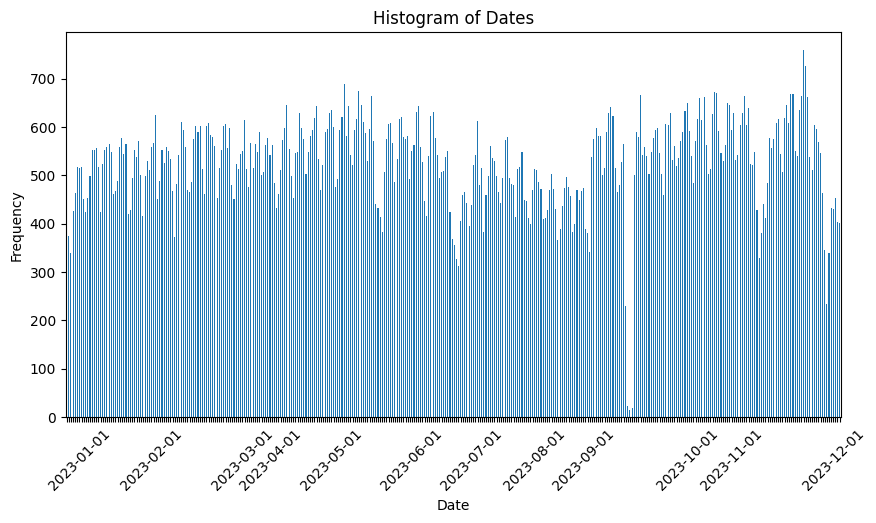

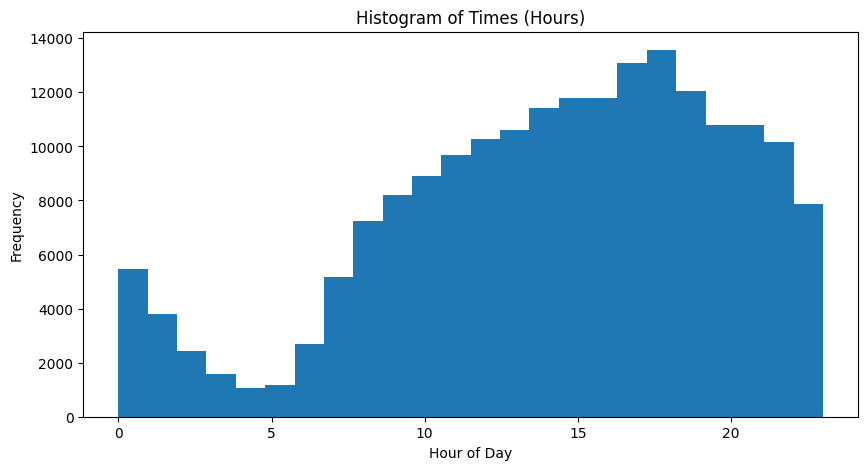

In [ ]:
# Plot histogram of dates
# Sample code to plot the histogram
plt.figure(figsize=(10, 5))
combined_sample['tpep_pickup_datetime'].dt.date.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Dates')

# Generate the list of first days of each month in the data range
date_range = combined_sample['tpep_pickup_datetime'].dt.date
first_of_month = pd.date_range(start=date_range.min(), end=date_range.max(), freq='MS').date

# Set the ticks on the x-axis to show only the first day of each month
plt.xticks(
    ticks=range(len(date_range.unique())),
    labels=[date if date in first_of_month else '' for date in date_range.unique()],
    rotation=45
)

plt.show()

# Plot histogram of times (hours) across the day
plt.figure(figsize=(10, 5))
combined_sample['tpep_pickup_datetime'].dt.hour.plot(kind='hist', bins=24)
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Histogram of Times (Hours)')
plt.show()

In [ ]:

dates_below_hundred = combined_sample['tpep_pickup_datetime'].dt.date.value_counts()
dates_below_hundred = dates_below_hundred[dates_below_hundred < 100].sort_index()

# Display the dates and their frequencies
print(dates_below_hundred)

tpep_pickup_datetime
2008-12-31     1
2023-09-22    23
2023-09-23    15
2023-09-24    18
Name: count, dtype: int64


In [ ]:
# prompt: plot scatters for combined_sample

# Assuming 'combined_sample' DataFrame is already created and available.

# Create scatter plots for numerical features against each other

# Select numerical features (excluding date/time)
numerical_cols = combined_sample.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('passenger_count')
numerical_cols.remove('trip_distance')

# Create pair plot
sns.pairplot(combined_sample[numerical_cols], diag_kind='kde')
plt.show()

## Location Encoding

In [14]:
# Create a dictionary to store coordinates for each LocationID
file_name = '/content/drive/MyDrive/CSE151GP/taxi_zones.tsv'

data = pd.read_csv(file_name, sep='\t')  # Use sep='\t' for tab-separated values
location_coords = {}
for index, row in data.iterrows():  # Iterate through each row of 'data' DataFrame
    location_id = row['LocationID']

    # Handle missing geometry data
    if type(row['the_geom']) == float:
        coordx, coordy = 0, 0  # Or any default values you prefer
    else:
        # Extract coordinates from the_geom string
        coords_str = row['the_geom'].replace("MULTIPOLYGON", "").replace("(", "").replace(")", "").strip().split(',')
        mean_coords = []
        for pair in coords_str:
            cords = pair.split()
            mean_coords.append([float(cords[0]), float(cords[1])])
        coordx, coordy = np.mean([x[0] for x in mean_coords]), np.mean([x[1] for x in mean_coords])
    location_coords[location_id] = (coordx, coordy)

In [15]:
def processPickupLocation(df):

    # Add coordx and coordy columns to df based on PULocationID
    df['coordx'] = df['PULocationID'].map(lambda location_id: location_coords.get(location_id, (0, 0))[0])
    df['coordy'] = df['PULocationID'].map(lambda location_id: location_coords.get(location_id, (0, 0))[1])
    for index, row in df.iterrows():
      if row['coordx'] == 0:
        print(row)
    # 0-1 normalization
    df['coordx'] = df['coordx'] + 100 # dirty trick
    print(df['coordy'].max())
    print(df['coordy'].min())
    df['coordx'] = (df['coordx'] - df['coordx'].min()) / (df['coordx'].max() - df['coordx'].min())
    df['coordy'] = (df['coordy'] - df['coordy'].min()) / (df['coordy'].max() - df['coordy'].min())
    #return df

In [16]:
def remove_location_rows(df, location_ids):

  filtered_df = df[df['PULocationID'].isin(location_coords)]
  filtered_df = filtered_df[filtered_df['DOLocationID'].isin(location_coords)]

  num_removed = len(df) - len(filtered_df)

  print(f"Number of rows removed: {num_removed}")
  df = filtered_df
  return df

## Time encoding

In [17]:
# prompt: Write a method that can read a df, pick out the coloum called tpep_pickup_datetime and read the date from this format: 2023-12-31 23:21:58 into format: number of days since year began (int), number of seconds since the day began(int), a variable indicating what day of the week it was, and one variable indicating if it was  a holiday, and which holiday it was
# Create a list of dates in 2023
dates_2023 = pd.date_range(start='2023-01-01', end='2023-12-31').to_list()
# Initialize the US holidays for 2023
us_holidays = holidays.US(years=2023)
print(us_holidays)

{datetime.date(2023, 1, 1): "New Year's Day", datetime.date(2023, 1, 2): "New Year's Day (observed)", datetime.date(2023, 5, 29): 'Memorial Day', datetime.date(2023, 6, 19): 'Juneteenth National Independence Day', datetime.date(2023, 7, 4): 'Independence Day', datetime.date(2023, 9, 4): 'Labor Day', datetime.date(2023, 11, 11): 'Veterans Day', datetime.date(2023, 11, 10): 'Veterans Day (observed)', datetime.date(2023, 11, 23): 'Thanksgiving', datetime.date(2023, 12, 25): 'Christmas Day', datetime.date(2023, 1, 16): 'Martin Luther King Jr. Day', datetime.date(2023, 2, 20): "Washington's Birthday"}


In [18]:
# Create a dictionary to store holiday information
holiday_dict = {}
for date in dates_2023:
   if date in us_holidays:
       holiday_dict[date] = us_holidays.get(date)
holiday_dict

{Timestamp('2023-01-01 00:00:00'): "New Year's Day",
 Timestamp('2023-01-02 00:00:00'): "New Year's Day (observed)",
 Timestamp('2023-01-16 00:00:00'): 'Martin Luther King Jr. Day',
 Timestamp('2023-02-20 00:00:00'): "Washington's Birthday",
 Timestamp('2023-05-29 00:00:00'): 'Memorial Day',
 Timestamp('2023-06-19 00:00:00'): 'Juneteenth National Independence Day',
 Timestamp('2023-07-04 00:00:00'): 'Independence Day',
 Timestamp('2023-09-04 00:00:00'): 'Labor Day',
 Timestamp('2023-11-10 00:00:00'): 'Veterans Day (observed)',
 Timestamp('2023-11-11 00:00:00'): 'Veterans Day',
 Timestamp('2023-11-23 00:00:00'): 'Thanksgiving',
 Timestamp('2023-12-25 00:00:00'): 'Christmas Day'}

In [19]:
def process_datetime(df):
  # Check if the 'tpep_pickup_datetime' column exists
  if 'tpep_pickup_datetime' not in df.columns:
    print("Error: 'tpep_pickup_datetime' column not found in DataFrame.")
    return df


  #Check if the coloumn is in datetime format:
  if not pd.api.types.is_datetime64_any_dtype(df['tpep_pickup_datetime']):
    print("Potential Error: 'tpep_pickup_datetime' column is not in datetime format.")
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])




  # Extract year from the datetime column
  df['year'] = df['tpep_pickup_datetime'].dt.year


  # Calculate the number of days since the year began
  df['sine_days_since_year_began'] = np.sin((df['tpep_pickup_datetime'].dt.dayofyear - 1)*2*np.pi/364)
  df['cosine_days_since_year_began'] = np.cos((df['tpep_pickup_datetime'].dt.dayofyear - 1)*2*np.pi/364)




  # Calculate the number of seconds since the day began
  df['sine_seconds_since_day_began'] = np.sin((df['tpep_pickup_datetime'].dt.second + \
                                  df['tpep_pickup_datetime'].dt.minute * 60 + \
                                  df['tpep_pickup_datetime'].dt.hour * 3600)*2*np.pi/86400)
  df['cos_seconds_since_day_began'] = np.cos((df['tpep_pickup_datetime'].dt.second + \
                                  df['tpep_pickup_datetime'].dt.minute * 60 + \
                                  df['tpep_pickup_datetime'].dt.hour * 3600)*2*np.pi/86400)


  # Get the day of the week (Monday=0, Sunday=6)
  df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek


  # Initialize US holidays for the year of the data
  year = df['tpep_pickup_datetime'].dt.year.iloc[0]  # Get the year from the data
  us_holidays = holidays.US(years=year)
  holiday_set = set(us_holidays.keys())
  # Create holiday columns
  current_date = df['tpep_pickup_datetime'].dt.date

  df['holiday_today'] = current_date.where(current_date.isin(holiday_set), None).map(lambda x: 1 if x is not None else 0)

  df['DateOffset'] = pd.DateOffset(days=1)

  df['day_after_holiday'] = current_date - pd.DateOffset(days=1)

  df['holiday_yesterday'] =df['day_after_holiday'].apply(lambda date: 1 if date in us_holidays else 0)

  df['day_before_holiday'] = current_date + df['DateOffset']

  df['holiday_tomorrow'] = df['day_before_holiday'].apply(lambda date: 1 if date in us_holidays else 0)
  # lambda if we want the holiday as the input "lambda date: us_holidays.get(date) if date in us_holidays else None"

  #return df


## Processing passenger count

In [20]:
def process_passenger_count(df):
  median_passenger = df['passenger_count'].median()
  df['passenger_count'] = df['passenger_count'].fillna(median_passenger).mask(df['passenger_count'] ==0 , median_passenger)

## Preparing data for training

In [132]:
processing_data = pd.DataFrame()
for df in df_list:
  processing_data = pd.concat([processing_data, df.sample(frac=0.01, random_state=42)])

processing_data = remove_location_rows(processing_data, location_coords)
process_passenger_count(processing_data)
processPickupLocation(processing_data)
process_datetime(processing_data)

Number of rows removed: 6373
40.90010738774882
40.52993928435698


In [133]:
train_df, test_df = train_test_split(processing_data, test_size = 0.2,random_state = 1)

In [134]:
# prompt: print allt the columns of processing_data

processing_data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Airport_fee',
       'coordx', 'coordy', 'year', 'sine_days_since_year_began',
       'cosine_days_since_year_began', 'sine_seconds_since_day_began',
       'cos_seconds_since_day_began', 'day_of_week', 'holiday_today',
       'DateOffset', 'day_after_holiday', 'holiday_yesterday',
       'day_before_holiday', 'holiday_tomorrow'],
      dtype='object')

In [135]:
X_train = train_df[['passenger_count', 'sine_days_since_year_began', 'cosine_days_since_year_began',
       'sine_seconds_since_day_began', 'cos_seconds_since_day_began',
       'day_of_week', 'holiday_today',
       'holiday_yesterday', 'holiday_tomorrow', 'coordx', 'coordy']]
y_train = train_df['DOLocationID']
X_test = test_df[['passenger_count', 'sine_days_since_year_began', 'cosine_days_since_year_began',
       'sine_seconds_since_day_began', 'cos_seconds_since_day_began',
       'day_of_week', 'holiday_today',
       'holiday_yesterday', 'holiday_tomorrow',  'coordx', 'coordy']]
y_test = test_df['DOLocationID']

In [136]:
print(len(y_train.unique()))
print(len(y_test.unique()))

255
245


In [137]:
def print_values(df):
  """Prints the average value of all numerical columns in a DataFrame.

  Args:
    df: The pandas DataFrame.
  """
  numerical_cols = df.select_dtypes(include=np.number).columns  # Select numerical columns
  for col in numerical_cols:
    avg_value = df[col].mean()
    min_value = df[col].min()
    max_value = df[col].max()
    print(f"column{col} has average: {avg_value}, minimum: {min_value} and maximum: {max_value}")

print(print_values(X_train))

columnpassenger_count has average: 1.3723534505927673, minimum: 1.0 and maximum: 8.0
columnsine_days_since_year_began has average: 0.01564389016973991, minimum: -1.0 and maximum: 1.0
columncosine_days_since_year_began has average: 0.01635020408959669, minimum: -1.0 and maximum: 1.0
columnsine_seconds_since_day_began has average: -0.3166152467518178, minimum: -1.0 and maximum: 1.0
columncos_seconds_since_day_began has average: -0.12007065581783867, minimum: -1.0 and maximum: 1.0
columnday_of_week has average: 3.000471161279833, minimum: 0 and maximum: 6
columnholiday_today has average: 0.025190538285172023, minimum: 0 and maximum: 1
columnholiday_yesterday has average: 0.02967320651795224, minimum: 0 and maximum: 1
columnholiday_tomorrow has average: 0.0281203651168115, minimum: 0 and maximum: 1
columncoordx has average: 0.5211294701705936, minimum: 0.0 and maximum: 1.0
columncoordy has average: 0.5946974866105916, minimum: 0.0 and maximum: 1.0
None


## Milestone 3 model

In [166]:
# prompt: one hot encode y_test to create a y_test_encoded

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.values.reshape(-1, 1))
y_test_encoded = enc.transform(y_test.values.reshape(-1, 1)).toarray()
y_train_encoded = enc.transform(y_train.values.reshape(-1, 1)).toarray()

In [196]:
# prompt: write a multinomial logistic regression to predict a one hot encoded y predictor

# Initialize and train the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500) # Increased max_iter
model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.05350504514073287


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Test accuracy

In [197]:
probabilities = model.predict_proba(X_test)
top_5_indices = np.argsort(probabilities, axis=1)[:, -5:]
is_correct = np.zeros(len(y_test.values), dtype=bool)
for i in range(len(y_test.values)):
  is_correct[i] = np.isin(y_test.values[i], top_5_indices[i])
accuracy = np.mean(is_correct)
print(f"Top-5 Accuracy: {accuracy}")




Top-5 Accuracy: 0.01964949548592671


### Train Accuracy

In [201]:
probabilities = model.predict_proba(X_train)
top_5_indices = np.argsort(probabilities, axis=1)[:, -5:]
is_correct = np.zeros(len(y_train.values), dtype=bool)
for i in range(len(y_train.values)):
  is_correct[i] = np.isin(y_train.values[i], top_5_indices[i])
accuracy = np.mean(is_correct)
print(f"Top-5 Accuracy: {accuracy}")



Top-5 Accuracy: 0.005011949017525226


### Plotting

In [ ]:
%%capture
iters = [5, 10, 50, 100, 500]
MSEs = []
train_MSEs = []
for iter in iters:
  # Initialize and train the multinomial logistic regression model
  short_trained_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=iter) # Increased max_iter
  short_trained_model.fit(X_train, y_train)


  # Make predictions on the test set
  y_pred = short_trained_model.predict(X_test)

  mse = np.mean(np.sum((y_test_encoded - short_trained_model.predict_proba(X_test))**2, axis=1))

  MSEs.append(mse)
  train_mse = np.mean(np.sum((y_train_encoded - short_trained_model.predict_proba(X_train))**2, axis=1))
  train_MSEs.append(train_mse)


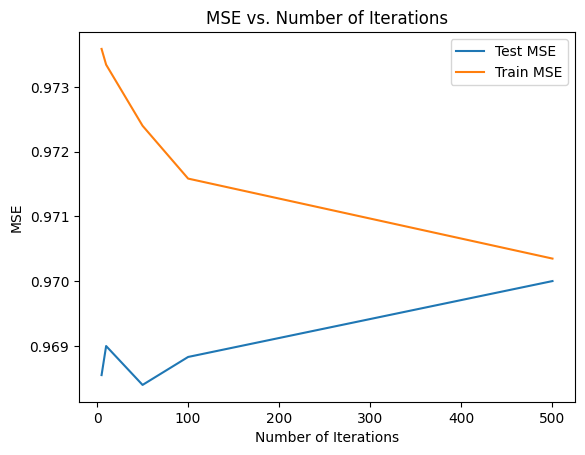

In [ ]:
plt.plot(iters, MSEs)
plt.plot(iters, train_MSEs)
plt.xlabel('Number of Iterations')
plt.ylabel('MSE')
plt.title('MSE vs. Number of Iterations')
plt.legend(['Test MSE', 'Train MSE'])
plt.show()

## Milestone 4 model

In [85]:
model = MLPClassifier(hidden_layer_sizes=(400,10), max_iter=100, random_state=42, solver = 'adam', validation_fraction=0.2)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(400, 10), max_iter=100, random_state=42,
              validation_fraction=0.2)

Text(0, 0.5, 'Loss')

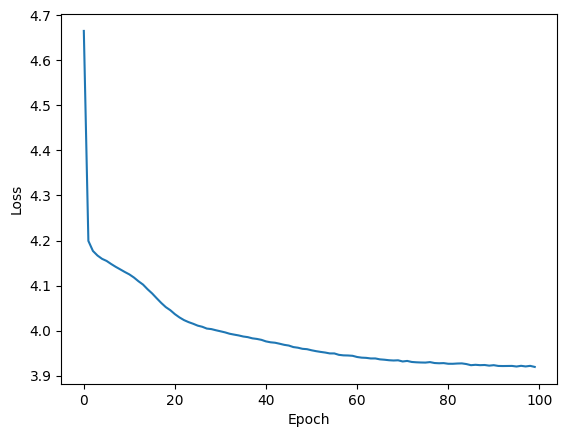

In [86]:
plt.plot(model.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Accuracy of first guess

In [87]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.06585236325013277


### Testing accuracy

In [88]:
probabilities = model.predict_proba(X_test)
top_5_indices = model.classes_[np.argsort(probabilities, axis=1)[:, -5:]]
is_correct = np.zeros(len(y_test.values), dtype=bool)
for i in range(len(y_test.values)):
  is_correct[i] = np.isin(y_test.values[i], top_5_indices[i])
accuracy = np.mean(is_correct)
print(f"Top-5 Accuracy: {accuracy}")



Top-5 Accuracy: 0.2591609134360064


### Training accuracy

In [82]:
probabilities = model.predict_proba(X_train)
top_5_indices = model.classes_[np.argsort(probabilities, axis=1)[:, -5:]]
is_correct = np.zeros(len(y_train.values), dtype=bool)
for i in range(len(y_train.values)):
  is_correct[i] = np.isin(y_train.values[i], top_5_indices[i])
accuracy = np.mean(is_correct)
print(f"Top-5 Accuracy: {accuracy}")



Top-5 Accuracy: 0.2597915560276155


## Milestone 4 Pytorch model

In [138]:
num_labels = max(train_df['DOLocationID'].max(), test_df['DOLocationID'].max())+1


In [141]:
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define your custom dataset
class TaxiDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the MLP model with tunable depth
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers=1):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.ReLU())

        # Hidden layers
        for _ in range(num_hidden_layers - 1): # Add more hidden layers if num_hidden_layers > 1
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Create dataset and data loader
dataset = TaxiDataset(X_train, y_train) # Assuming X_train and y_train are your training data

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Adjust batch_size as needed
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Instantiate the model, loss function, and optimizer
input_size = X_train.shape[1] # Number of features
hidden_size = 128 # Hidden size as needed
output_size = num_labels # Number of output classes
num_hidden_layers = 10 # Number of hidden layers as needed
model = MLP(input_size, hidden_size, output_size, num_hidden_layers=num_hidden_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
most_correct = 0
best_model = None
num_epochs = 10 # Number of epochs as needed
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # # Print progress (optional)
        # if batch_idx % 100 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")



    # Validation
    model.eval()
    corrects = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            # Forward pass
            outputs = model(data)
            if target in torch.topk(outputs.flatten(), 5).indices:
              corrects += 1
    if corrects > most_correct:
      most_correct = corrects
      best_model = model
      print('model updated')
    acc = corrects/val_loader.__len__()
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation accuracy: {acc:.4f}")

print("Training completed!")

Using device: cpu
Epoch [1/10], Validation Loss: 0.2232
Epoch [2/10], Validation Loss: 0.2290
Epoch [3/10], Validation Loss: 0.2399
Epoch [4/10], Validation Loss: 0.2413
Epoch [5/10], Validation Loss: 0.2460
Epoch [6/10], Validation Loss: 0.2495
Epoch [7/10], Validation Loss: 0.2571
Epoch [8/10], Validation Loss: 0.2577
Epoch [9/10], Validation Loss: 0.2613
Epoch [10/10], Validation Loss: 0.2686
Training completed!


### Testing accuracy

In [142]:
test_dataset = TaxiDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
corrects = 0
with torch.no_grad():
  for batch_idx, (data, target) in enumerate(test_loader):
      # Forward pass
      outputs = best_model(data)
      if y_test.iloc[batch_idx] in torch.topk(outputs.flatten(), 5).indices:
        corrects += 1

  print(corrects/len(y_test))

0.2709500172537361


### Training accuracy

In [150]:
corrects = 0
total_samples = 0  # Keep track of total samples

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        outputs = best_model(data)
        _, predicted = torch.topk(outputs, 5, dim=1)  # Get top 5 predictions for each sample

        # Check if target is in top 5 predictions for each sample
        corrects += (predicted == target.unsqueeze(1)).any(dim=1).sum().item()

        total_samples += target.size(0)  # Add batch size to total samples

    accuracy = corrects / total_samples
    print(f"Training accuracy: {accuracy}")

Training accuracy: 0.27023798661169773
